# The idea

The present study aims to research how different syntactic relations interact with the possibility of head nouns and their dependents to be in different verses in a Russian poetic text.

The hypothesis is that the more distant the relation is in syntactic terms, the easier for a constituent is to be split into different verses. For some syntactic relations it is clear which relations are more "close" and which are less. For example, most syntax theories suppose that subjects are projected along with the V-DO complex, while adverbs can adjoin constituents, including both S and V-DO. The example of the described structure is: \[Вчера \[Вася \[встретил \[соседа\]\]\]\]. Thus, the direct object in this structure is closest to the verb, the subject is farther and the adverb is even farther.

It is not clear how to compare the described relations inside verbal / sentential projections and the relations with other heads, but some tests, e. g. based on word order, lead to a conclusion that the relations inside NP are more fixed than in verbal / sentential projections. In this study I will restrict the set of discussed relations to Adv, S, DO in the verbal domain and Adj in the nominal domain.

The hypothesis is thus that the more is a relation on the right of the hierarchy _Adv > S > DO > Adj_, the less freely the dependents must be able to occur on a different verse from its head.

The database that I create is really big, so I don't upload it to GitHub. It can be found by the link: https://disk.yandex.com/d/E0QFIUVjxj8x9A

On comments and discussion: I try to keep in comments the ones that are related to the HW requirements, while the substantial discussion of the data and the conclusions are given in separate sells.

In [1]:
import spacy
import sqlite3
import pandas as pd
import numpy
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import chisquare
import statsmodels.formula.api as smf

In [2]:
def int_check_none(a):
    if a == None:
        return None
    else:
        return int(a)

def decadize(date):
    if date == None:
        return None
    else:
        return int(date) // 50 * 50

I use the collection of poetic texts, provided by Ilia Gusev: https://github.com/IlyaGusev/PoetryCorpus/blob/master/datasets/corpus/all.xml. See more on the collection here: https://github.com/IlyaGusev/PoetryCorpus.

The collection is preproсesed and turned into a database, consisting of 3 tables. The first one comprises information about each text, inсluding meta-information, the second one — information about verses, the third one — information about separate words, including morphological and syntactic tags and information about the head of the word.

In [3]:
tree = ET.parse('all.xml')
root = tree.getroot()

In [4]:
nlp = spacy.load("ru_core_news_md")

In [ ]:
#Creating a database; includes working with syntactic and morphological parsing
#Table 1: meta-information
#Table 2: verses (it is not really needed in the task, but I am required to
#provide 3 tables; the table itself is not senseless
#and can be used to deal with rhythm, rhyme and so on.)
#Table 3: words
#Notice that creation of the database requires quite a long time


con = sqlite3.connect("poetry.db")
c = con.cursor()

c.execute("DROP TABLE IF EXISTS meta")
c.execute("CREATE TABLE meta (id,author,year,half_century,name);")

c.execute("DROP TABLE IF EXISTS verses")
c.execute("CREATE TABLE verses (id,id_in_poem,poem_id,text);")

c.execute("DROP TABLE IF EXISTS words")
c.execute("CREATE TABLE words (id,word,id_in_poem,verse_id,poem_id,lemma,POS,morph_tags,synt_tag,head,head_id);")

word_id = 0

verse_id = 0

verse_id_words = 0

for i, poem in enumerate(root):
    
    verse_sizes = []
        
    verse_size = 0
        
    verse_id_words_in_poem = 0
    
    c.execute("INSERT INTO meta VALUES (?, ?, ?, ?, ?)",
              (i, poem[1].text, int_check_none(poem[2].text), decadize(poem[2].text), poem[4].text))
  
    for j, verse in enumerate(poem[3].text.split('\n')):
        
        verse_size += len(nlp(verse))
        
        verse_sizes.append(verse_size)
              
        c.execute("INSERT INTO verses VALUES (?, ?, ?, ?)",
              (verse_id, j, i, verse))
        
        verse_id += 1
    
    poem_analyzed = nlp(poem[3].text.replace('\n', ' '))
    
    for id_in_poem, word in enumerate(poem_analyzed):
                   
        c.execute("INSERT INTO words VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)",
          (word_id, str(word), id_in_poem, verse_id_words, i,
           word.lemma_, word.pos_, str(word.morph), word.dep_, str(word.head), 
           word.head.i + (word_id - word.i)))
        
        word_id += 1
        
        if verse_sizes[verse_id_words_in_poem] <= id_in_poem:
            verse_id_words_in_poem += 1
            verse_id_words += 1
        
    verse_id_words_in_poem += 1
    verse_id_words += 1
        
con.commit()

con.close()

In [5]:
con = sqlite3.connect("poetry.db")
c = con.cursor()    

In [6]:
#Creating dataframes from the database

words = pd.read_sql_query("SELECT * FROM words", con)
words

,id,word,id_in_poem,verse_id,poem_id,lemma,POS,morph_tags,synt_tag,head,head_id
0,0,Забывши,0,0,0,забывши,NOUN,Animacy=Anim|Case=Nom|Gender=Masc|Number=Sing,nsubj,жил,6
1,1,волнения,1,0,0,волнение,NOUN,Animacy=Inan|Case=Gen|Gender=Neut|Number=Sing,nmod,Забывши,0
2,2,жизни,2,0,0,жизнь,NOUN,Animacy=Inan|Case=Gen|Gender=Fem|Number=Sing,nmod,волнения,1
3,3,мятежной,3,0,0,мятежный,ADJ,Case=Gen|Degree=Pos|Gender=Fem|Number=Sing,nmod,жизни,2
4,4,",",4,0,0,",",PUNCT,,punct,Забывши,0
...,...,...,...,...,...,...,...,...,...,...,...
2767238,2767238,-,302,486638,16693,-,ADV,Degree=Pos,parataxis,погасло,2767233
2767239,2767239,Высоко,303,486638,16693,высоко,ADV,Degree=Pos,obl,погасло,2767233
2767240,2767240,и,304,486639,16693,и,CCONJ,,cc,красно,2767241
2767241,2767241,красно,305,486639,16693,красный,ADJ,Animacy=Inan|Case=Acc|Degree=Pos|Gender=Neut|N...,conj,Высоко,2767239


In [7]:
meta = pd.read_sql_query("SELECT * FROM meta", con)
meta

,id,author,year,half_century,name
0,0,Михаил Лермонтов,1829.0,1800.0,Забывши волнения жизни мятежной...
1,1,Сергей Есенин,1917.0,1900.0,"Нивы сжаты, рощи голы..."
2,2,Игорь Северянин,1919.0,1900.0,ЧАРЫ ЛЮЧИНЬ
3,3,Анатолий Жигулин,1963.0,1950.0,Золото
4,4,Николай Тихонов,1937.0,1900.0,Хоровод в Сульдуси
...,...,...,...,...,...
16689,16689,Леонид Мартынов,1967.0,1950.0,Ноябрь
16690,16690,Гаврила Державин,1798.0,1750.0,Параше
16691,16691,Федор Сологуб,1880.0,1850.0,Рифма
16692,16692,Илья Эренбург,1924.0,1900.0,Я так любил тебя — до грубых шуток...


In [8]:
verses = pd.read_sql_query("SELECT * FROM verses", con)
verses

,id,id_in_poem,poem_id,text
0,0,0,0,"Забывши волнения жизни мятежной,"
1,1,1,0,Один жил в пустыне рыбак молодой.
2,2,2,0,"Однажды на скале прибрежной,"
3,3,3,0,Над тихой прозрачной рекой
4,4,4,0,Он с удой беспечно
...,...,...,...,...
486635,486635,63,16693,Не захотел - а сжег.
486636,486636,64,16693,"Гори, гори ясно,"
486637,486637,65,16693,"Чтобы не погасло,"
486638,486638,66,16693,Чтобы не напрасно -


In [9]:
con.close()

In [10]:
#Manipulations with the dataframes 1: joining two dataframes to understand in which verse is a head of a word

head_verses = words.loc[:, ['head_id', 'verse_id']].join(
    words.loc[:, ['id', 'verse_id']].set_index('id'),
    on='head_id', validate='m:1', rsuffix = '_head')

words['verse_id_head'] = head_verses['verse_id_head']

In [11]:
#Manipulations with the dataframes 2: creating a coloumn by condition

words['Head_verse'] = numpy.where(words['verse_id'] == words['verse_id_head'], 'same', 'different')

In [12]:
#Manipulations with the dataframes 3: filtering rows with sertain tags

words_some_relations = words.loc[:, 
        ['synt_tag', 'Head_verse']][words['synt_tag'].isin(
        ['nsubj', 'obj', 'amod', 'advmod'])]

Manipulations with the data above led to the dataset, including nominal subjects, objects, adjectival and adverbial modifiers. For each of them the information is contained if the word is in the same verse as its head or they are in different ones.

Clearly, some part of the database is not immediately needed in the study or is not needed in it at all. However, this data can be used in other research of Russian poetry.

In [13]:
#Manipulations with the dataframes 4: aggregating data

transitions = words_some_relations.groupby(["synt_tag", 'Head_verse']).size()
transitions = transitions.reset_index(name='n')
transitions['fraction'] = transitions.groupby('synt_tag')['n'].transform(lambda x: round(x/sum(x), 2))
transitions

,synt_tag,Head_verse,n,fraction
0,advmod,different,61907,0.33
1,advmod,same,123729,0.67
2,amod,different,31726,0.20
3,amod,same,124773,0.80
4,nsubj,different,118585,0.46
5,nsubj,same,139393,0.54
6,obj,different,44035,0.36
7,obj,same,76962,0.64


The table shows the number of the words with its head in the same and in different verses and percentages of both for each syntactic relation.

The hypothesis proved to be  partially correct: the order in the hierarchy is _S > Adv > DO > Adj_ with an adverb at the different position.

This order is also theoretically reasonable, as adverbs are not a homogeneous class. While some adverbs, like _вчера_ are expected to be "farther" from the verb, some others, like _быстро_ are placed between S and DO. It appears that the number of the adverbs of the second type is higher than the number of the first type. (It is pleasing from the theoretical point of view that Adv is between S and DO. However, the difference between Adv and DO is not very big, though significant because of the large number of the sample, so it might be reasonable to merge them on the hierarchy.)

The difference between groups is clearly visible on the histogram below. For almost a half of nominal subjects the head is in a separate verse, for adjective modifiers the head in most cases in the same verse, while direct objects and adverbs are in between.

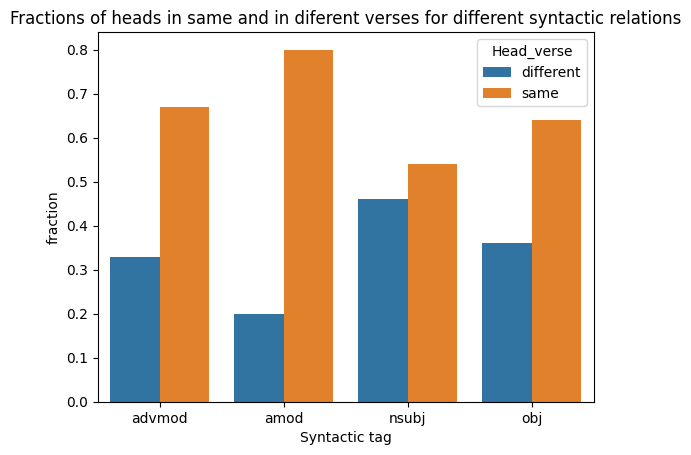

In [14]:
#Plot 1

sns.barplot(x="synt_tag", y="fraction", hue='Head_verse', data=transitions)
plt.title('Fractions of heads in same and in diferent verses for different syntactic relations')
plt.xlabel('Syntactic tag')
plt.ylabel('fraction');

To check the significance of the observed difference, I count χ-square for the contaguancy table below:

In [15]:
cont_table_head_verses = transitions.pivot_table(values='n', index=['Head_verse'],
                        columns=['synt_tag'], aggfunc=numpy.sum)
cont_table_head_verses

synt_tag,advmod,amod,nsubj,obj
Head_verse,,,,
different,61907,31726,118585,44035
same,123729,124773,139393,76962


The difference is statistically significant with incredibly small p-value (which is not surprising, regarding the size of the dataset).

In [16]:
# Additional task: statistical inference

chisquare(cont_table_head_verses, axis=None)

Power_divergenceResult(statistic=133918.76441042282, pvalue=0.0)

The observed differences may turn out to be epiphenomenal and, for example, follow from the fact that closer syntactic constituents are usually also close in the sense of the number of words between them.

The latter assumption appears to be true, as it is shown below. Both mean, and quartiles, and violin plots show that the closeness of the dependent to its head (where 1 stands for _right near the head_ 2 is _separated by 1 word from it_ and so on) aligns with the same hierarchy _S > Adv > DO > Adj_.

(The violin plots are chosen, as they better represent the kind of data that I have: one of axes is categorical, while the other concentrates near 1, so boxplots and other quantile-oriented graphs do not show much)

In [17]:
#More manipulations with the dataframes

words['head_distance'] = abs(words['id'] - words['head_id'])

words_some_relations_distances = words.loc[:, ['synt_tag', 'head_distance']][words['synt_tag'].isin(
        ['nsubj', 'obj', 'amod', 'advmod'])]


words_some_relations_distances.groupby('synt_tag').agg(Mean=('head_distance', numpy.mean),
                        quartile_1=('head_distance', lambda a: numpy.quantile(a, 0.25)),
                        quartile_3=('head_distance', lambda a: numpy.quantile(a, 0.75)))

,Mean,quartile_1,quartile_3
synt_tag,,,
advmod,1.889849,1.0,2.0
amod,1.274813,1.0,1.0
nsubj,2.656548,1.0,3.0
obj,2.248047,1.0,2.0


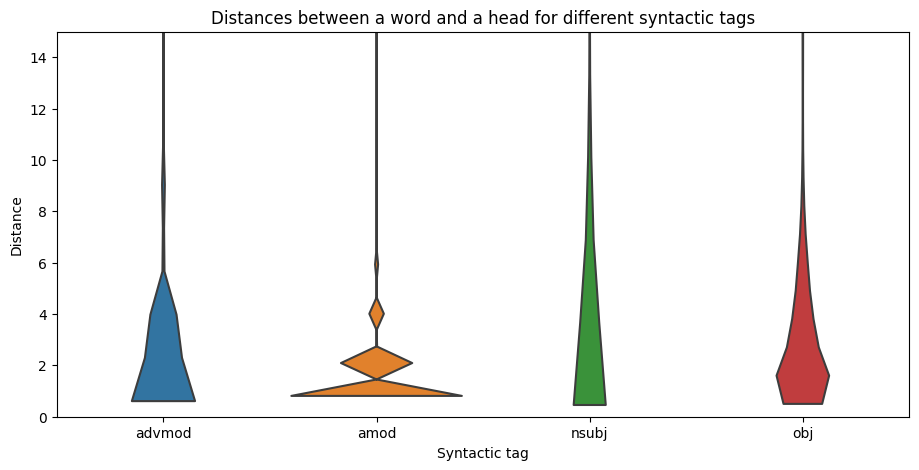

In [18]:
#Plot 2

plt.figure(figsize=(11, 5))
sns.violinplot(x='synt_tag', y='head_distance', data=words_some_relations_distances, inner=None,
               order=['advmod', 'amod', 'nsubj', 'obj'])
plt.ylim((0, 15))

plt.title('Distances between a word and a head for different syntactic tags')
plt.xlabel('Syntactic tag')
plt.ylabel('Distance')
plt.show()

Notice, however, that the difference between syntactic relations in linear distance from the head is not as dramatic as in same / different verse opposition: 75% of nouns are not farther than 3 from their heads, while almost half of them are in a different verse.

This observation is supported by the fact that the size of a verse in words is usually bigger than 3. As it is shown in the Plot 3 and in the table before it, numbers of words in a verse concentrate near 5 in one verse.

The statement made, of course, requires statistical proof. The possible way to prove it is to create a synthetic dataset with four types of tokens with distributions, similar to pictured above (e. g. lognormal), randomly distribute them over synthetic verses (with some length) and check, if it will lead to the picture on Prot 1. The described proof is outside of the scope of this homework.

In [19]:
verse_sizes = words.loc[:, ['id', 'verse_id']].join(
    verses.loc[:, ['id']].set_index('id'),
    on='verse_id', validate='m:1').groupby('verse_id').count().reset_index().groupby('id').count()

verse_sizes.head(10)

,verse_id
id,
1,5414
2,17113
3,44043
4,82702
5,98891
6,89130
7,63113
8,40297
9,22802


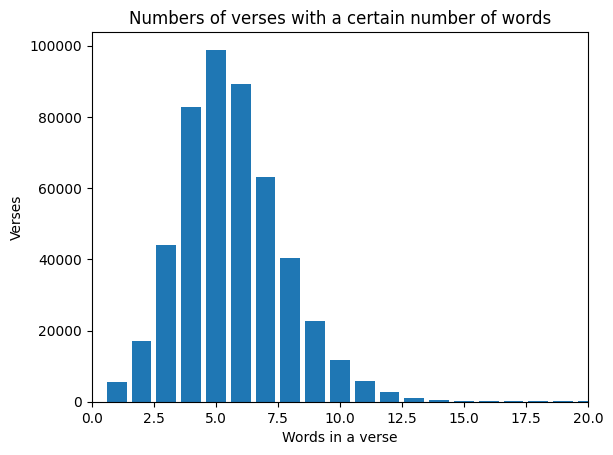

In [20]:
#Plot 3

plt.xlim(0, 20)
plt.bar('id', 'verse_id', data=verse_sizes.reset_index())
plt.title('Numbers of verses with a certain number of words')
plt.xlabel('Words in a verse')
plt.ylabel('Verses')
plt.show()

Another fact that shows that linear distance between a word and its head and being in the same and in a different verse are not absolutely robustly connected is that they show different development over time.

The latter grows over time (Plot 4), which is expected, because poetry changes from more strict in the classical period to more flexible nowadays.

Interestingly, linear distance between a word and its head slightly decreases over time (Plot 5), going to the opposite direction from the expected from how the same / different verse distribution develops.

(I used a random sample of 100000 words: this number is more than enough to draw conclusions and can be handled from a technical point of view. For fitting the same / different verse distribution I chose logistic regression, because it is a categorical variable with two values and a numeric predictor. For fitting linear distance I use a linear regression model. It does not suit the structure of data perfectly, but allows us to see the trend.)

In [21]:
for_timeline = words.loc[:, ['poem_id', 'synt_tag', 'Head_verse', 'head_distance']].join(
    meta.loc[:, ['id', 'year']].set_index('id'),
    on='poem_id', validate='m:1')

for_timeline = for_timeline[words['synt_tag'].isin(['nsubj', 'obj', 'amod', 'advmod'])].dropna()
for_timeline = for_timeline.replace({'Head_verse':{'same':0, 'different':1}})

sample_for_timeline = for_timeline.sample(50000)
sample_for_timeline

,poem_id,synt_tag,Head_verse,head_distance,year
1408296,8561,nsubj,1,1,1780.0
1414811,8599,advmod,0,1,1963.0
709069,4367,obj,0,1,1938.0
534739,3307,advmod,0,1,1861.0
820309,5054,obj,0,2,1814.0
...,...,...,...,...,...
235806,1447,advmod,1,14,1907.0
607660,3750,nsubj,1,1,1946.0
1310313,8009,nsubj,0,1,1967.0
1399473,8510,nsubj,1,1,1954.0


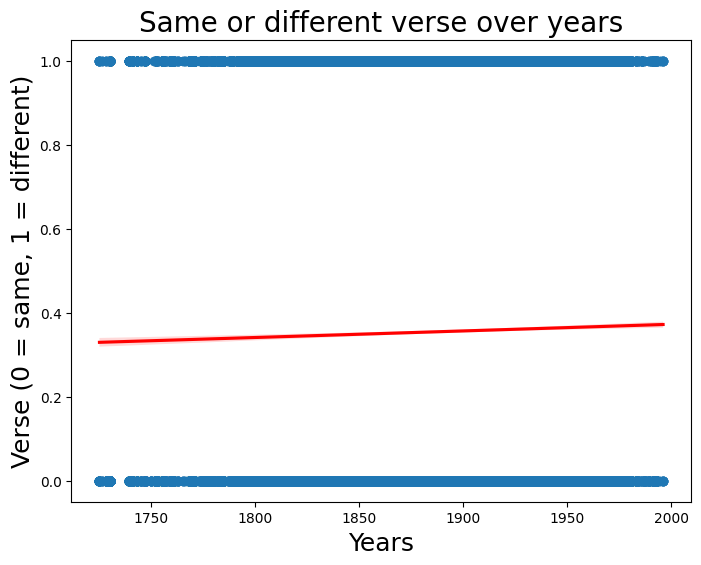

In [27]:
#Plot 4

sample_for_timeline = for_timeline.sample(75000)

plt.figure(figsize=(8, 6))

sns.regplot(x='year', y='Head_verse', data=sample_for_timeline, line_kws={"color": "red"}, logistic=True)
plt.title('Same or different verse over years', size=20)
plt.xlabel('Years', size=18)
plt.ylabel('Verse (0 = same, 1 = different)', size=18);

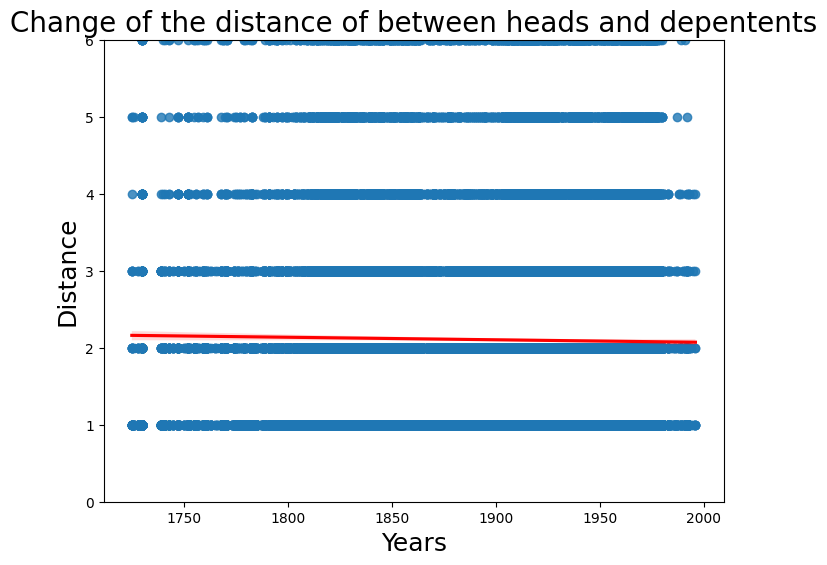

In [28]:
#Plot 5

plt.figure(figsize=(8, 6))

sns.regplot(x='year', y='head_distance', data=sample_for_timeline, line_kws={"color": "red"})
plt.title('Change of the distance of between heads and depentents', size=20)
plt.ylim((0, 6))
plt.xlabel('Years', size=18)
plt.ylabel('Distance', size=18);

As it is shown below, for both regressions "Year" predictor is statistically significant with a very small p-value for same / different verse opposition and bigger p-value for linear distance (but the latter lowers with the growth of sample size).

In [29]:
# Additional task: statistical inference for same or different verses over years

mod_log = smf.logit('Head_verse~year', data=sample_for_timeline)
fit_year_verse = mod_log.fit()
fit_year_verse.summary()

Optimization terminated successfully.
         Current function value: 0.651091
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Head_verse   No. Observations:                75000
Model:                          Logit   Df Residuals:                    74998
Method:                           MLE   Df Model:                            1
Date:                Sun, 30 Oct 2022   Pseudo R-squ.:               0.0002772
Time:                        02:33:26   Log-Likelihood:                -48832.
converged:                       True   LL-Null:                       -48845.
Covariance Type:            nonrobust   LLR p-value:                 1.949e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.8971      0.251     -7.547      0.000      -2.390      -1.404
year           0.0007      0.000      5.198      0.000       0.000       0.001
==============================================================================
"""

In [30]:
# Additional task: statistical inference for change of the distance of between heads and depentents

mod_linear = smf.ols('head_distance~year', data=sample_for_timeline)
fit_year_distance = mod_linear.fit()
fit_year_distance.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          head_distance   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.987
Date:                Sun, 30 Oct 2022   Prob (F-statistic):             0.0459
Time:                        02:33:26   Log-Likelihood:            -1.7813e+05
No. Observations:               75000   AIC:                         3.563e+05
Df Residuals:                   74998   BIC:                         3.563e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7267      0.312      8.739      0.000       2.115       3.338
year          -0.0003      0.000     -1.997      0.046      -0.001   -6.05e-06
==============================================================================
Omnibus:                   117369.328   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        270242042.966
Skew:                           9.470   Prob(JB):                         0.00
Kurtosis:                     296.460   Cond. No.                     6.24e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.24e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Conclusions

In the present study I showed that the different syntactic relations behave differently with respect to the acceptability / probability for a dependent to be outside of the verse where its head is. The relations align with the following hierarchy _S > Adv > DO > Adj_, where the rightmost S appears on a different line in almost a half of cases, while leftmost Adj does it only 1 of 5 times. The difference between relations is statistically significant.

This finding partly confirms the original hypothesis about the ordering of syntactic relations, with the exception of adverb modifiers behavior. The latter, however, can be explained with heterogeneity of adverb class.

Finally, interaction of the same / different verses opposition and the linear distance between a head and a dependent was discussed. Some arguments that support that the former does not purely follow from the latter, including a diacronical argument, were given.

The study leaves several questions for further research. How do different classes of adverbs behave? How does the size of a verse as a parameter interact with the overall picture? Can other parameters, such as genre, affect the distributions? All these questions are still to be answered.

## On project

I am sorry, I do not have the idea of my project yet... I have put all my energy into this homework and now I have a crisis of ideas... I hope I will find something!